In [1]:
BATCH_SIZE = 1024

PAD_SIZE = 80
TARGET_LABELS = [
    "Improvement",
    "Solved",
    #"AreaRatio",
    #"Stacks"
]

SEED = 3093453

# Preprocessing

## Load Packages and Data

In [2]:
import os
import sys

import numpy as np
import pandas as pd
import polars as pl

import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

# Random Seeds
np.random.seed(SEED)
tf.random.set_seed(SEED)



# Cosmetics
np.set_printoptions(
    edgeitems=30,
    linewidth=100_000,
    suppress=True
    )

sns.set(
    context="talk",
    style="darkgrid"
)


cwd = os.getcwd()
cwd, _ = os.path.split(cwd)

In [3]:
import tensorflow as tf
from tensorflow import keras

train_samples = os.path.join(cwd, "data", "train") # 116586 + 489623 = 606209
test_samples = os.path.join(cwd, "data", "validation")

train_dataset = keras.preprocessing.text_dataset_from_directory(
    directory = train_samples,
    labels = None,
    batch_size = BATCH_SIZE,
    max_length = None,
    shuffle = True,
    seed = SEED,
    validation_split = 0.1,
    subset = "training",
    follow_links = False
)

val_dataset = keras.preprocessing.text_dataset_from_directory(
    directory = train_samples,
    labels = None,
    batch_size = BATCH_SIZE,
    max_length = None,
    shuffle = True,
    seed = SEED,
    validation_split = 0.1,
    subset = "validation",
    follow_links = False
)



Found 489623 files belonging to 1 classes.
Using 440661 files for training.


2024-02-10 18:38:53.921233: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-02-10 18:38:53.921308: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-02-10 18:38:53.921312: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-02-10 18:38:53.921546: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-10 18:38:53.921573: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 489623 files belonging to 1 classes.
Using 48962 files for validation.


In [4]:
for X in train_dataset.take(1):
    pass

df = pl.DataFrame({"raw": X.numpy().astype(str)})
print(df[0, 0])

dataset: B
instance: MA2
+-----------+
2D Packing MIP with Time Limit 15 [s] in Truck P355037001
Stack 0 with items: ['0090016200_26102022000265', '0090016200_26102022000255']
Stack 1 with items: ['0090016200_26102022012372', '0090016200_26102022012372', '0090016200_26102022017816']
Stack 2 with items: ['0090016200_26102022006635', '0090016200_26102022002470', '0090016200_26102022013378']
Stack 3 with items: ['0090016200_26102022015271', '0090016200_26102022007589', '0090016200_26102022015271']
Stack 4 with items: ['0090016200_26102022001327', '0090016200_26102022001327']
Stack 5 with items: ['0090016200_26102022015678', '0090016200_26102022004493', '0090016200_26102022015678']
Stack 6 with items: ['0090016200_26102022019753', '0090016200_26102022019604', '0090016200_26102022019753']
Stack 7 with items: ['0090016200_26102022016002', '0090016200_26102022016002', '0090016200_26102022016002']
Stack 8 with items: ['0090016200_26102022012624', '0090016200_26102022012624', '0090016200_261020

## Loading CSVs

In [5]:
folder = "truck-item-infos"
file = "items.csv"

item_path = os.path.join(cwd, folder, file)
items = pl.read_csv(source = item_path);

items = items.lazy().with_columns([
    (pl.col("Item ident").alias("item_id")),
    (pl.col("Length") / 1000), # mm to m
    (pl.col("Width") / 1000),  # mm to m
    (pl.col("Height") / 1000), # mm to m
    (pl.col("Nesting height") / 1000), # mm to m
    (pl.col("Weight") / 1000), # kg to tons
    (pl.col("Forced orientation") == "lengthwise").alias("ForcedLength"),
    (pl.col("Forced orientation") == "widthwise").alias("ForcedWidth"),
    ((pl.col("Height") - pl.col("Nesting height")) / 1000).alias("NestedHeight"),
    pl.col("dataset").str.extract("([A-Z])")
]).drop([
    "Forced orientation", "Max stackability", "Inventory cost",
    "Earliest arrival time", "Latest arrival time", "Number of items",
    "instance_id",
    "Stackability code",
    "Item ident", # drop because of rename earlier
    # Unnecassary columns
    "Product code",
    "Package",
    "Plant code",
    "Product code",
    "Package code",
    "NestedHeight"
]).unique()

items.collect()

Supplier code,Supplier dock,Plant dock,Length,Width,Height,Weight,Nesting height,dataset,instance,item_id,ForcedLength,ForcedWidth
i64,str,str,f64,f64,f64,f64,f64,str,str,str,bool,bool
679301,null,"""169GB-20""",2.4,1.2,1.62,0.457104,0.045,"""C""","""BY""","""0090016900_270…",false,false
3043102,null,"""169GD-60""",1.2,1.0,0.93,0.123752,0.045,"""C""","""BY""","""0090016900_270…",false,false
22060301,null,"""169GB-10""",1.6,1.2,0.93,0.467056,0.045,"""C""","""BY""","""0090016900_270…",false,false
23676305,null,"""169GD-60""",1.9,1.2,1.38,0.27635,0.045,"""C""","""BY""","""0090016900_270…",false,false
1925700,null,"""GRF1""",2.4,2.1,1.49,0.5186,0.045,"""C""","""BY""","""0090016900_270…",false,false
7908416,null,"""169GB-20""",3.2,2.0,0.51,1.622924,0.045,"""C""","""BY""","""0090016900_270…",false,false
6681302,null,"""169GD-60""",1.206,1.01,1.093,0.08744,0.0,"""C""","""BY""","""0090016900_270…",false,false
22060301,null,"""169GB-10""",2.6,1.2,1.49,0.48964,0.045,"""C""","""BY""","""0090016900_270…",false,false
2573225,null,"""169GB-10""",1.6,1.2,0.75,0.3353,0.045,"""C""","""BY""","""0090016900_270…",false,false


In [6]:
file = "trucks.csv"

truck_path = os.path.join(cwd, folder, file)

truck_clms = ["Id truck", "dataset", "instance",
              "Supplier code", "Supplier dock", "Plant dock",
              "Supplier loading order", "Supplier dock loading order", "Plant dock loading order",
             ]

truck_stops = (
    pl.read_csv(source = truck_path, columns = truck_clms)
    .lazy()
    .rename({"Id truck": "truck_id"})
    .sort(["dataset", "instance", "truck_id"])
    .with_columns([pl.col("dataset").str.extract("(\w)")])
    .unique()
)
truck_stops.collect()

Supplier code,Supplier loading order,Supplier dock,Supplier dock loading order,Plant dock,Plant dock loading order,truck_id,dataset,instance
i64,i64,str,i64,str,i64,str,str,str
29908700,1,null,1,"""X4""",1,"""P187730403""","""A""","""AS"""
29908700,1,null,1,"""X4""",1,"""P187730407""","""A""","""AS"""
29908700,1,null,1,"""X4""",1,"""P188730401""","""A""","""AS"""
29908700,1,null,1,"""X4""",1,"""P192730401""","""A""","""AS"""
62069600,1,null,1,"""X1""",1,"""P192730503""","""A""","""AS"""
62059600,1,null,1,"""X0""",1,"""P192731005""","""A""","""AS"""
28091900,1,null,1,"""X4""",1,"""P194708201""","""A""","""AS"""
29908700,1,null,1,"""X4""",1,"""P194730403""","""A""","""AS"""
62060800,1,null,1,"""X2""",1,"""P194731305""","""A""","""AS"""


In [7]:
file = "trucks.csv"

truck_path = os.path.join(cwd, folder, file)

truck_clms = ["Id truck", "dataset", "instance",
              "Length", "Width", "Max weight",
              "EMmm", "EMmr"
             ]

truck_dims = (
    pl.read_csv(source = truck_path, columns = truck_clms)
    .lazy()
    .rename({"Id truck": "truck_id", "Max weight": "Weight"})
    .sort(["dataset", "instance", "truck_id"])
    .with_columns([pl.col("dataset").str.extract("(\w)")])
    .unique()
)

truck_dims = truck_dims.with_columns([
    (pl.col("Length") / 1000),
    (pl.col("Width") / 1000),
    (pl.col("Weight") / 1000),
    (pl.col("EMmm") / 1000),
    (pl.col("EMmr") / 1000),
])

truck_dims.collect()

truck_id,Length,Width,Weight,EMmm,EMmr,dataset,instance
str,f64,f64,f64,f64,f64,str,str
"""P187721701""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""
"""P187731005""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""
"""P188721401""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""
"""P188730401""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""
"""P189709601""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""
"""P192730407""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""
"""P193731001""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""
"""P194721701""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""
"""P196721701""",14.94,2.5,24.0,12.0,31.5,"""A""","""AS"""


## Preprocessing Functions:

In [8]:
import sys
sys.path.append("..")

from utils.preprocessing import input_output_generation

In [9]:
cx, cy = input_output_generation(
    X,
    #target_labels=TARGET_LABELS,
    pad_size=PAD_SIZE,
    shuffle=False,
    items=items,
    truck_stops=truck_stops,
    truck_dims=truck_dims,
)

In [10]:
cx[0][0, :40]

array([[ 1.2       ,  1.        ,  0.37984   ,  0.        ,  0.        ,  1.        ,  0.        ,  0.03999996,  0.44000006],
       [ 1.2       ,  1.        ,  0.424516  ,  0.        ,  0.        ,  1.        ,  0.        ,  0.03999996,  0.44000006],
       [ 1.2       ,  1.        ,  0.577192  ,  0.        ,  0.        ,  1.        ,  0.        ,  0.03999996,  0.44000006],
       [ 1.2       ,  1.        ,  0.252146  ,  0.        ,  0.        ,  1.        ,  0.        ,  0.03999996,  0.44000006],
       [ 1.2       ,  1.        ,  0.377846  ,  0.        ,  0.        ,  1.        ,  0.        ,  0.03999996,  0.44000006],
       [ 1.206     ,  1.01      ,  0.2851    ,  0.        ,  0.        ,  1.        ,  0.        ,  0.02800012,  0.42000008],
       [ 1.206     ,  1.01      ,  0.3985    ,  0.        ,  0.        ,  1.        ,  0.        ,  0.02800012,  0.42000008],
       [ 1.206     ,  1.01      ,  0.07856   ,  0.        ,  0.        ,  1.        ,  0.        ,  0.02800012,  0.420

# DNN

### Optimizer, Losses and Metrics

In [11]:
# Learning Rate
initial_lr = 10e-3 # 10e-3
lr_decay = 0.9995

# Optimizer
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = initial_lr)

In [12]:
loss_solved = tf.keras.losses.BinaryFocalCrossentropy(
    gamma=2,
    alpha = cy[0].mean(),
    name='solved_focal_loss'
)

loss_improvement = tf.keras.losses.BinaryFocalCrossentropy(
    gamma=1.5,
    alpha = cy[1].mean(),
    name='improvement_focal_loss'
)

loss_area_ratio = tf.keras.losses.BinaryCrossentropy(
    name='area_ratio_crossentropy'
)



loss_stacks = tf.keras.losses.BinaryFocalCrossentropy(
    gamma=6,
    alpha = cy[-1].mean(),
    name='stacks_focal_loss'
)

for i, target in enumerate(TARGET_LABELS):
    print(f"{target} Prevalence: {cy[i].mean():.1%}")

Improvement Prevalence: 37.9%
Solved Prevalence: 46.6%


In [13]:
target_loss_objects = {
    "Solved": loss_solved,
    "Improvement": loss_improvement,
    "AreaRatio": loss_area_ratio,
    "Stacks": loss_stacks,
}

loss_objects = [target_loss_objects[target] for target in TARGET_LABELS]
mean_losses = [tf.keras.metrics.Mean(name=target) for target in TARGET_LABELS]

In [14]:
all_target_metrics: list[list[tf.keras.metrics]] = {
    "Solved": [
        tf.keras.metrics.Precision(name = "PRC"),
        tf.keras.metrics.Recall(name = "SNS"),
        tf.keras.metrics.AUC(curve='PR', name="AUC"),
        tf.keras.metrics.BinaryAccuracy(name = "ACC")
    ],
    "Improvement": [
        tf.keras.metrics.Precision(name = "PRC"),
        tf.keras.metrics.Recall(name = "SNS"),
        tf.keras.metrics.AUC(curve='PR', name="AUC"),
        tf.keras.metrics.BinaryAccuracy(name = "ACC")
    ],
    "AreaRatio": [
        keras.metrics.RootMeanSquaredError(name="RMSE"),
        keras.metrics.MeanAbsoluteError(name="MAE")
    ],
    "Stacks": [
        tf.keras.metrics.Precision(name = "PRC"),
        tf.keras.metrics.Recall(name = "SNS"),
        tf.keras.metrics.AUC(curve='PR', name="AUC"),
        tf.keras.metrics.BinaryAccuracy(name = "ACC")
    ],
}

all_metrics = [all_target_metrics[target] for target in TARGET_LABELS]

## Architecture

In [15]:
from tensorflow.keras.layers import Masking, BatchNormalization, MultiHeadAttention, LayerNormalization, Dropout
from tensorflow.keras.layers import Add, Dense, Input, Reshape, Permute, Lambda, Concatenate
from keras import backend as K
from tensorflow.keras import Model

from utils.DNN.model_layers import TransformerEncoder



def build_model(
    # input data dependent
    target_labels: list[str]=["Improvement"],
    n_features: int=9,
    pad_size: int=80,

    # hyperparameters in descending relevance
    n_blocks: int=3,
    num_heads: int=3,
    upscale_factor: float=1,
    encoder_dropout: float=0.1,
    activation: str="gelu", # "relu" "gelu" "selu" "swish"
    
    # additional experimental features
    use_bias: bool=True,
    split_last_layer: bool=False,
    use_PreLN: bool=True,
    bias_regularizer=None,
) -> Model:
    """
    Creates the encoder model according to the hyperparamters.
    """

    # Input
    input_stack_level = Input(shape=(pad_size, n_features), name="StackLevelInputFeatures", dtype=tf.float16,)
    input_time_limit = Input(shape=(1), name="TimeLimitInput", dtype=tf.float16,)
    inputs = [input_stack_level, input_time_limit]
    
    # Masking padded input
    masking_layer = Masking(
        mask_value=0,
        input_shape=(pad_size, n_features),
        dtype=tf.float16,
        name="MaskingLayer"
    )
    x = masking_layer(input_stack_level)

    #batch_norm_layer = BatchNormalization(name="BatchNormalizationLayer")
    #x = batch_norm_layer(masking_layer)
    
    key_dim = int(n_features/num_heads)
    # Encoder Block
    for i in range(1, n_blocks+1):
        # Self attention with add and layer norm
        self_attention_layer = TransformerEncoder(
            num_heads=num_heads,
            #key_dim=int(n_features/num_heads),
            activation=activation,
            units = n_features,
            upscale_factor=upscale_factor,
            dropout=encoder_dropout,
            use_bias=use_bias,
            use_PreLN=use_PreLN,
            bias_regularizer=bias_regularizer,
            idx = i,
        )
        x, _ = self_attention_layer(x)
    
    final_layer_norm = LayerNormalization(name="FinalLayerNorm")
    x = final_layer_norm(x)

    if split_last_layer:
        self_attention_layer_solved = TransformerEncoder(
            num_heads=num_heads,
            #key_dim=key_dim,
            activation=activation,
            units = n_features,
            upscale_factor=upscale_factor,
            dropout=encoder_dropout,
            use_bias=use_bias,
            use_PreLN=use_PreLN,
            bias_regularizer=bias_regularizer,
            idx="Solved"
        )
        attention_solved, _ = self_attention_layer_solved(x)
        attention_solved = final_layer_norm(attention_solved)
        
        self_attention_layer_improvement = TransformerEncoder(
            num_heads=num_heads,
            #key_dim=key_dim,
            activation=activation,
            units = n_features,
            upscale_factor=upscale_factor,
            dropout=encoder_dropout,
            use_bias=use_bias,
            use_PreLN=use_PreLN,
            bias_regularizer=bias_regularizer,
            idx="Improvement",
        )
        attention_improvement, _ = self_attention_layer_improvement(x)
        attention_improvement = final_layer_norm(attention_improvement)

        self_attention_layer_area_ratio = TransformerEncoder(
            num_heads=num_heads,
            #key_dim=key_dim,
            activation=activation,
            units = n_features,
            upscale_factor=upscale_factor,
            dropout=encoder_dropout,
            use_bias=use_bias,
            use_PreLN=use_PreLN,
            bias_regularizer=bias_regularizer,
            idx="AreaRatio",
        )
        
        attention_area_ratio, _ = self_attention_layer_area_ratio(x)
        attention_area_ratio = final_layer_norm(attention_area_ratio)




    
    
    # After Attention, reduce to single dimension
    add_across_dim = Lambda(
        lambda x: K.sum(x, axis=1)/pad_size**1,
        output_shape=lambda s: (s[0], s[2]),
        name = "ReduceStackDimensionViaSummation"
    )
    
    reshape = Lambda(lambda x: tf.squeeze(x), name="Output")
    
    # Pipe Attention directly into missing stack prediction:
    
    output_stacks = Dense(1, activation='sigmoid', name = "PredictionStacks")
    xx = output_stacks(x)
    output_stacks = reshape(xx)
    
    
    
    # Standardize the Time Limit
    # - The time limit ranges from 0 to 30,
    # - (tl - 15)/5 should roughly normalize
    
    normalize_time_limit = Lambda(
        lambda x: (x-15)/5,
        name = "StandardizeTimeLimit"
    )
    input_time_limit = normalize_time_limit(input_time_limit)
    concatenate_layer = Concatenate(axis=-1, name=f"ConcatenateLayer")
    #x = concatenate_layer([x, input_time_limit])
    
    
    
    
    
    if split_last_layer:
        attention_solved = add_across_dim(attention_solved)
        attention_improvement = add_across_dim(attention_improvement)
        attention_area_ratio = add_across_dim(attention_area_ratio)
    else:
        x = add_across_dim(x)

    if split_last_layer:
        xx = concatenate_layer([attention_solved, input_time_limit])
    else:
        xx = concatenate_layer([x, input_time_limit])
    fully_connected_layer_solved = Dense(units=n_features+1, activation=activation,name=f"FullyConnectedLayerSolved")
    xx = fully_connected_layer_solved(xx)
    output_solved = Dense(1, activation='sigmoid', name = "PredictionSolved")
    xx = output_solved(xx)
    output_solved = reshape(xx)



    if split_last_layer:
        xx = concatenate_layer([attention_improvement, input_time_limit])
    else:
        xx = concatenate_layer([x, input_time_limit])
    fully_connected_layer_improvement = Dense(units=n_features+1, activation=activation,name=f"FullyConnectedLayerImprovement")
    xx = fully_connected_layer_improvement(xx)
    output_improvement = Dense(1, activation='sigmoid', name = "PredictionImprovement")
    xx = output_improvement(xx)
    output_improvement = reshape(xx)

    if split_last_layer:
        xx = concatenate_layer([attention_area_ratio, input_time_limit])
    else:
        xx = concatenate_layer([x, input_time_limit])
    fully_connected_layer_area_ratio = Dense(units=n_features+1, activation=activation,name=f"FullyConnectedLayerAreaRatio")
    xx = fully_connected_layer_area_ratio(xx)
    output_area_ratio = Dense(1, activation='sigmoid', name = "PredictionAreaRatio")
    xx = output_area_ratio(xx)
    output_area_ratio = reshape(xx)
    
    
    
    
    target_outputs = {
        "Solved": output_solved,
        "Improvement": output_improvement,
        "AreaRatio": output_area_ratio,
        "Stacks": output_stacks
    }
    
    outputs = [target_outputs[target] for target in target_labels]
    
    model = Model(
        inputs=inputs,
        outputs=outputs,
    )
    
    return model

## Model Parameters

In [16]:
N_FEATURES = cx[0].shape[-1]

n_blocks=6
num_heads=4
encoder_dropout=0.1

patience = 3 # i.e three without improvement

model = build_model(
    target_labels=TARGET_LABELS,
    n_features=N_FEATURES,
    pad_size=PAD_SIZE,
    # Hyperparameters
    n_blocks=n_blocks,
    num_heads=num_heads,
    use_bias=True,
    upscale_factor=1.5,
    use_PreLN=True,
    split_last_layer=False,
    encoder_dropout=encoder_dropout,
    activation="gelu", # "relu" "gelu" "selu" "swish"
    bias_regularizer=None,
    #upscale_units=20
)

model

### Model Architecture Inspection:

In [17]:
_ = model(cx) # just check if it works
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 StackLevelInputFeatures (I  [(None, 80, 9)]              0         []                            
 nputLayer)                                                                                       
                                                                                                  
 MaskingLayer (Masking)      (None, 80, 9)                0         ['StackLevelInputFeatures[0][0
                                                                    ]']                           
                                                                                                  
 transformer_encoder (Trans  ((None, 80, 9),              613       ['MaskingLayer[0][0]']        
 formerEncoder)               (None, 4, 80, 80))                                              

In [18]:
for file_format in ["png", "jpg", "pdf",]:
    path = os.path.join(cwd, "plots", "2024-01-07-FinalModelTraining-Train+Val", f"FinalModelArchitecture.{file_format}")
    tf.keras.utils.plot_model(
        model,
        to_file=path,
        show_shapes=True
    )    

## Training Process Functions

In [19]:
def geometric_decay(epoch: int, initial_lr:float=10e-3, lr_decay:float=0.9) -> float:
    """
    Exponential decay learning rate schedule
    """
    return initial_lr * lr_decay**epoch

#xx = np.arange(5000)
#yy = geometric_decay(xx, lr_decay=0.9995)
#plt.plot(xx, yy);

In [20]:
def early_stopping(track:pd.DataFrame, patience: int=1, metric: str="Val-Loss", target: str="Improvement") -> bool:
    """
    Early Stopping if no improvement in the metrics after 'patience' epochs.

    Assumes that the metrics is a loss to be minimized.

    TODO:
    -----
    - include option to check for increases in metric rather than just decreases in loss
    """

    assert (type(patience) == int)
    assert (patience > 0)
    
    track = track.loc[(track["Metric"]==metric)&(track["Target"]==target), "Value"]
    
    current_value = track.iloc[-1]
    prior_values = track.tail(patience+1) # plus1 since, last value is 'current_value', would always return True

    # Check if there is an improvement
    #  check if the current value is better than
    #  any of the last patience values (excluding the current one)
    # Since the current value is included in the prior values
    #  we must not use geq!
    if np.any(prior_values > current_value) or (epoch < patience):
        # The current value is lower than past ones,
        # which in the case of loss constitutes an improvement
        return False
    else:
        print(f"Early Stopping after no Improvement in {metric} for {target} after {patience} epochs")
        return True

    
    

In [21]:
def print_status_bar(iteration, total, losses, all_metrics=None, training:bool=True):
    tabs = "\t\t\t\t\t\t\t\t\t\t\t\t\t\t"
    metrics = tabs.join([
        f"{TARGET_LABELS[i]:<12}\tLoss: {losses[i].result():.4f}" +
        "\t".join([
            f"{m.name:>10}: {m.result():.2%}"
            if m.name not in ["MAE", "RMSE"]
            else f"{m.name:>10}: {m.result():.4f}"
            for m in metrics
        ])
        for i, metrics in enumerate(all_metrics)
    ])
    
    if training:
        prefix="Training"
    else:
        prefix="Validation"
    
    print(f"\r{prefix}-Iteration: {iteration+1:0>3}/{total:<3}\tLR: {float(optimizer.lr):<1000.9f}" + metrics,
          end="")


In [22]:
@tf.function
def model_pass(model, inputs, targets, training):
    """
    Usual Tensorflow model passing of inputs throught the network.
    If in training mode, the optimizier can apply the gradients
    observed with GradientTape to the model parameters
    """
    
    with tf.GradientTape() as tape:
        
        outputs = model(inputs, training=training)

        # Single output is not a list!
        if type(outputs) != list:
            outputs = [outputs]
            
        losses = [l(t, o) for l,o,t in zip(loss_objects, outputs, targets)]
        
        if training:
            gradients = tape.gradient(losses, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            
        for i, mean_loss in enumerate(mean_losses):
            if len(mean_losses) <= 1:
                mean_loss(losses)
            else:
                mean_loss(losses[i])
        
    return outputs


In [23]:
def run_epoch(model, dataset, target_labels, all_metrics:list[list[tf.keras.metrics]],
              epoch:int, history:pd.DataFrame, training:bool=True,
              shuffle:bool=True):
    """
    Single epoch, running several training steps over a dataset
    """

    for step, X_batch in enumerate(dataset):
        
        X_batch, y_batch = input_output_generation(
            X_batch,
            items=items,
            truck_stops=truck_stops,
            truck_dims=truck_dims,
            target_labels=target_labels,
            shuffle=shuffle,
            pad_size=PAD_SIZE
        )
        
        outputs = model_pass(model, X_batch, y_batch, training=training)
        
        for i, metrics in enumerate(all_metrics):
            for metric in metrics:
                metric(y_batch[i].reshape(-1), outputs[i].numpy().reshape(-1))
    
        print_status_bar(step, len(dataset), mean_losses, all_metrics, training=training)
    
        #### LEARNING RATE UPDATE ####
        if training:
            optimizer.lr = geometric_decay((epoch-1)*len(dataset)+step, initial_lr, lr_decay)
    
    print("\n")

    #### UPDATE METRICS
    for i, metrics in enumerate(all_metrics):
        for metric in metrics:
            data = pd.DataFrame({
                "Epoch": [epoch],
                "Target": [target_labels[i]],
                "Metric": [metric.name if training else f"Val-"+metric.name],
                "Value": [float(metric.result())],
            })
            history = pd.concat([history, data])
            metric.reset_states()

    for i, mean_loss in enumerate(mean_losses):
        data = pd.DataFrame({
            "Epoch": [epoch],
            "Target": [target_labels[i]],
            "Metric": ["Loss" if training else f"Val-"+"Loss"],
            "Value": [float(mean_loss.result())],
        })
        history = pd.concat([history, data])
        mean_loss.reset_states()
            
    return model, history

## Model Training

In [24]:
n_epochs = 50

clms = ["Epoch", "Target", "Metric", "Value"]

track = pd.DataFrame(columns=clms)
    
# get losses and metrics
#loss_objects = [target_loss_objects[target] for target in target_labels]
#mean_losses = [tf.keras.metrics.Mean(name=target) for target in target_labels]
#all_metrics = [all_target_metrics[target] for target in target_labels]
    
    
for epoch in range(1, n_epochs+1):
    
    print(f"Epoch {epoch:0>3}/{ n_epochs:0>3}")
        
    model, track = run_epoch(model, train_dataset, TARGET_LABELS,
                             all_metrics, epoch=epoch, history=track, training=True, shuffle=True)
    model, track = run_epoch(model, val_dataset, TARGET_LABELS,
                             all_metrics, epoch=epoch, history=track, training=False, shuffle=True)
        
    # make an intermediate save of the model
    model_path = os.path.join(cwd, "models", f"FinalModelTraining-{epoch}.tf")
    model.save(model_path, overwrite=True)
    weight_path = os.path.join(cwd, "models", f"FinalModelTraining-{epoch}-weights.h5")
    model.save_weights(weight_path, overwrite=True)
        
    # Early Stopping
    if early_stopping(track, patience=patience):
        break
        
        print("-"*120)
    
        
        

Epoch 001/050


2024-02-10 18:39:34.311234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Training-Iteration: 431/431	LR: 0.008069015                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

/var/folders/j4/qmf6qmvd1gv0nctgx3m6jm3r0000gn/T/ipykernel_47402/1590848810.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  history = pd.concat([history, data])


Validation-Iteration: 048/48 	LR: 0.008064981                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/FinalModelTraining-1.tf/assets


Epoch 002/050
Training-Iteration: 431/431	LR: 0.006504391                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/FinalModelTraining-2.tf/assets


INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/FinalModelTraining-2.tf/assets


Epoch 003/050
Training-Iteration: 431/431	LR: 0.005243156                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/FinalModelTraining-3.tf/assets


INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/FinalModelTraining-3.tf/assets


Epoch 004/050
Training-Iteration: 431/431	LR: 0.004226481                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/FinalModelTraining-4.tf/assets


INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/FinalModelTraining-4.tf/assets


Epoch 005/050
Training-Iteration: 431/431	LR: 0.003406945                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/FinalModelTraining-5.tf/assets


INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/FinalModelTraining-5.tf/assets


Epoch 006/050
Training-Iteration: 431/431	LR: 0.002746320                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/FinalModelTraining-6.tf/assets


INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/FinalModelTraining-6.tf/assets


Epoch 007/050
Training-Iteration: 431/431	LR: 0.002213795                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/FinalModelTraining-7.tf/assets


INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/FinalModelTraining-7.tf/assets


Epoch 008/050
Training-Iteration: 431/431	LR: 0.001784528                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/FinalModelTraining-8.tf/assets


INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/FinalModelTraining-8.tf/assets


Epoch 009/050
Training-Iteration: 431/431	LR: 0.001438499                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/FinalModelTraining-9.tf/assets


INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/FinalModelTraining-9.tf/assets


Epoch 010/050
Training-Iteration: 431/431	LR: 0.001159567                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/FinalModelTraining-10.tf/assets


INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/FinalModelTraining-10.tf/assets


Epoch 011/050
Training-Iteration: 431/431	LR: 0.000934721                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/FinalModelTraining-11.tf/assets


INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/FinalModelTraining-11.tf/assets


Epoch 012/050
Training-Iteration: 431/431	LR: 0.000753474                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/FinalModelTraining-12.tf/assets


INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/FinalModelTraining-12.tf/assets


Epoch 013/050
Training-Iteration: 431/431	LR: 0.000607371                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/FinalModelTraining-13.tf/assets


INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/FinalModelTraining-13.tf/assets


Epoch 014/050
Training-Iteration: 431/431	LR: 0.000489599                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/FinalModelTraining-14.tf/assets


INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/FinalModelTraining-14.tf/assets


Epoch 015/050
Training-Iteration: 431/431	LR: 0.000394663                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/FinalModelTraining-15.tf/assets


INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/FinalModelTraining-15.tf/assets


Epoch 016/050
Training-Iteration: 431/431	LR: 0.000318136                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/FinalModelTraining-16.tf/assets


INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/FinalModelTraining-16.tf/assets


Epoch 017/050
Training-Iteration: 431/431	LR: 0.000256448                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/FinalModelTraining-17.tf/assets


INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/FinalModelTraining-17.tf/assets


Epoch 018/050
Training-Iteration: 431/431	LR: 0.000206721                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/FinalModelTraining-18.tf/assets


INFO:tensorflow:Assets written to: /Users/fynn/Uni/MA/models/FinalModelTraining-18.tf/assets


Early Stopping after no Improvement in Val-Loss for Improvement after 3 epochs


In [25]:
model_path = os.path.join(cwd, "models", f"FinalModelTraining-{epoch}.keras")
model.save(model_path, overwrite=True)
#model.save(model_path, overwrite=True, save_format="tf")
#model.save(model_path, overwrite=True, save_format="h5")
    

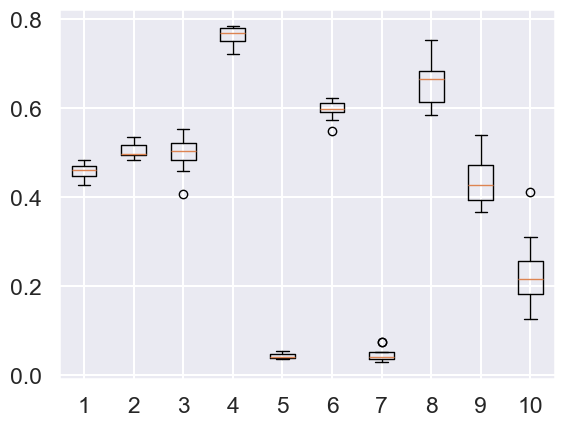

In [26]:
a = np.vstack([model([c[:10] for c in cx], training=True)[0] for i in range(10)])
plt.boxplot(a);

In [27]:
history = track\
    .pivot_table(
        values = ["Value"],
        columns=["Metric"],
        index=["Epoch", "Target"]
    )\
    .reset_index()\
    .set_index("Epoch", drop=True)

clms = history.columns
history.columns = [clm[i>=1] for i, clm in enumerate(clms)]
history

,Target,ACC,AUC,Loss,PRC,SNS,Val-ACC,Val-AUC,Val-Loss,Val-PRC,Val-SNS
Epoch,,,,,,,,,,,
1,Improvement,0.700291,0.754964,0.198715,0.682739,0.687996,0.754422,0.818843,0.174849,0.730874,0.761288
1,Solved,0.788538,0.820079,0.116265,0.824814,0.581372,0.821310,0.869817,0.104735,0.810409,0.711604
2,Improvement,0.764397,0.839219,0.167270,0.748347,0.758466,0.772803,0.839128,0.166324,0.767220,0.746223
2,Solved,0.830244,0.878095,0.097604,0.852480,0.683001,0.833401,0.887834,0.097573,0.809120,0.753717
3,Improvement,0.776683,0.857612,0.159431,0.763334,0.767157,0.777092,0.847130,0.166572,0.755975,0.780972
3,Solved,0.842198,0.892119,0.092089,0.859116,0.712258,0.841265,0.893194,0.094857,0.841090,0.734741
4,Improvement,0.784506,0.867626,0.154342,0.771647,0.775198,0.781422,0.862581,0.158777,0.746675,0.814297
4,Solved,0.849796,0.901247,0.088142,0.864082,0.729717,0.849230,0.901712,0.090011,0.837933,0.763960
5,Improvement,0.790490,0.874377,0.150786,0.777519,0.782238,0.785875,0.868924,0.156004,0.775912,0.769749


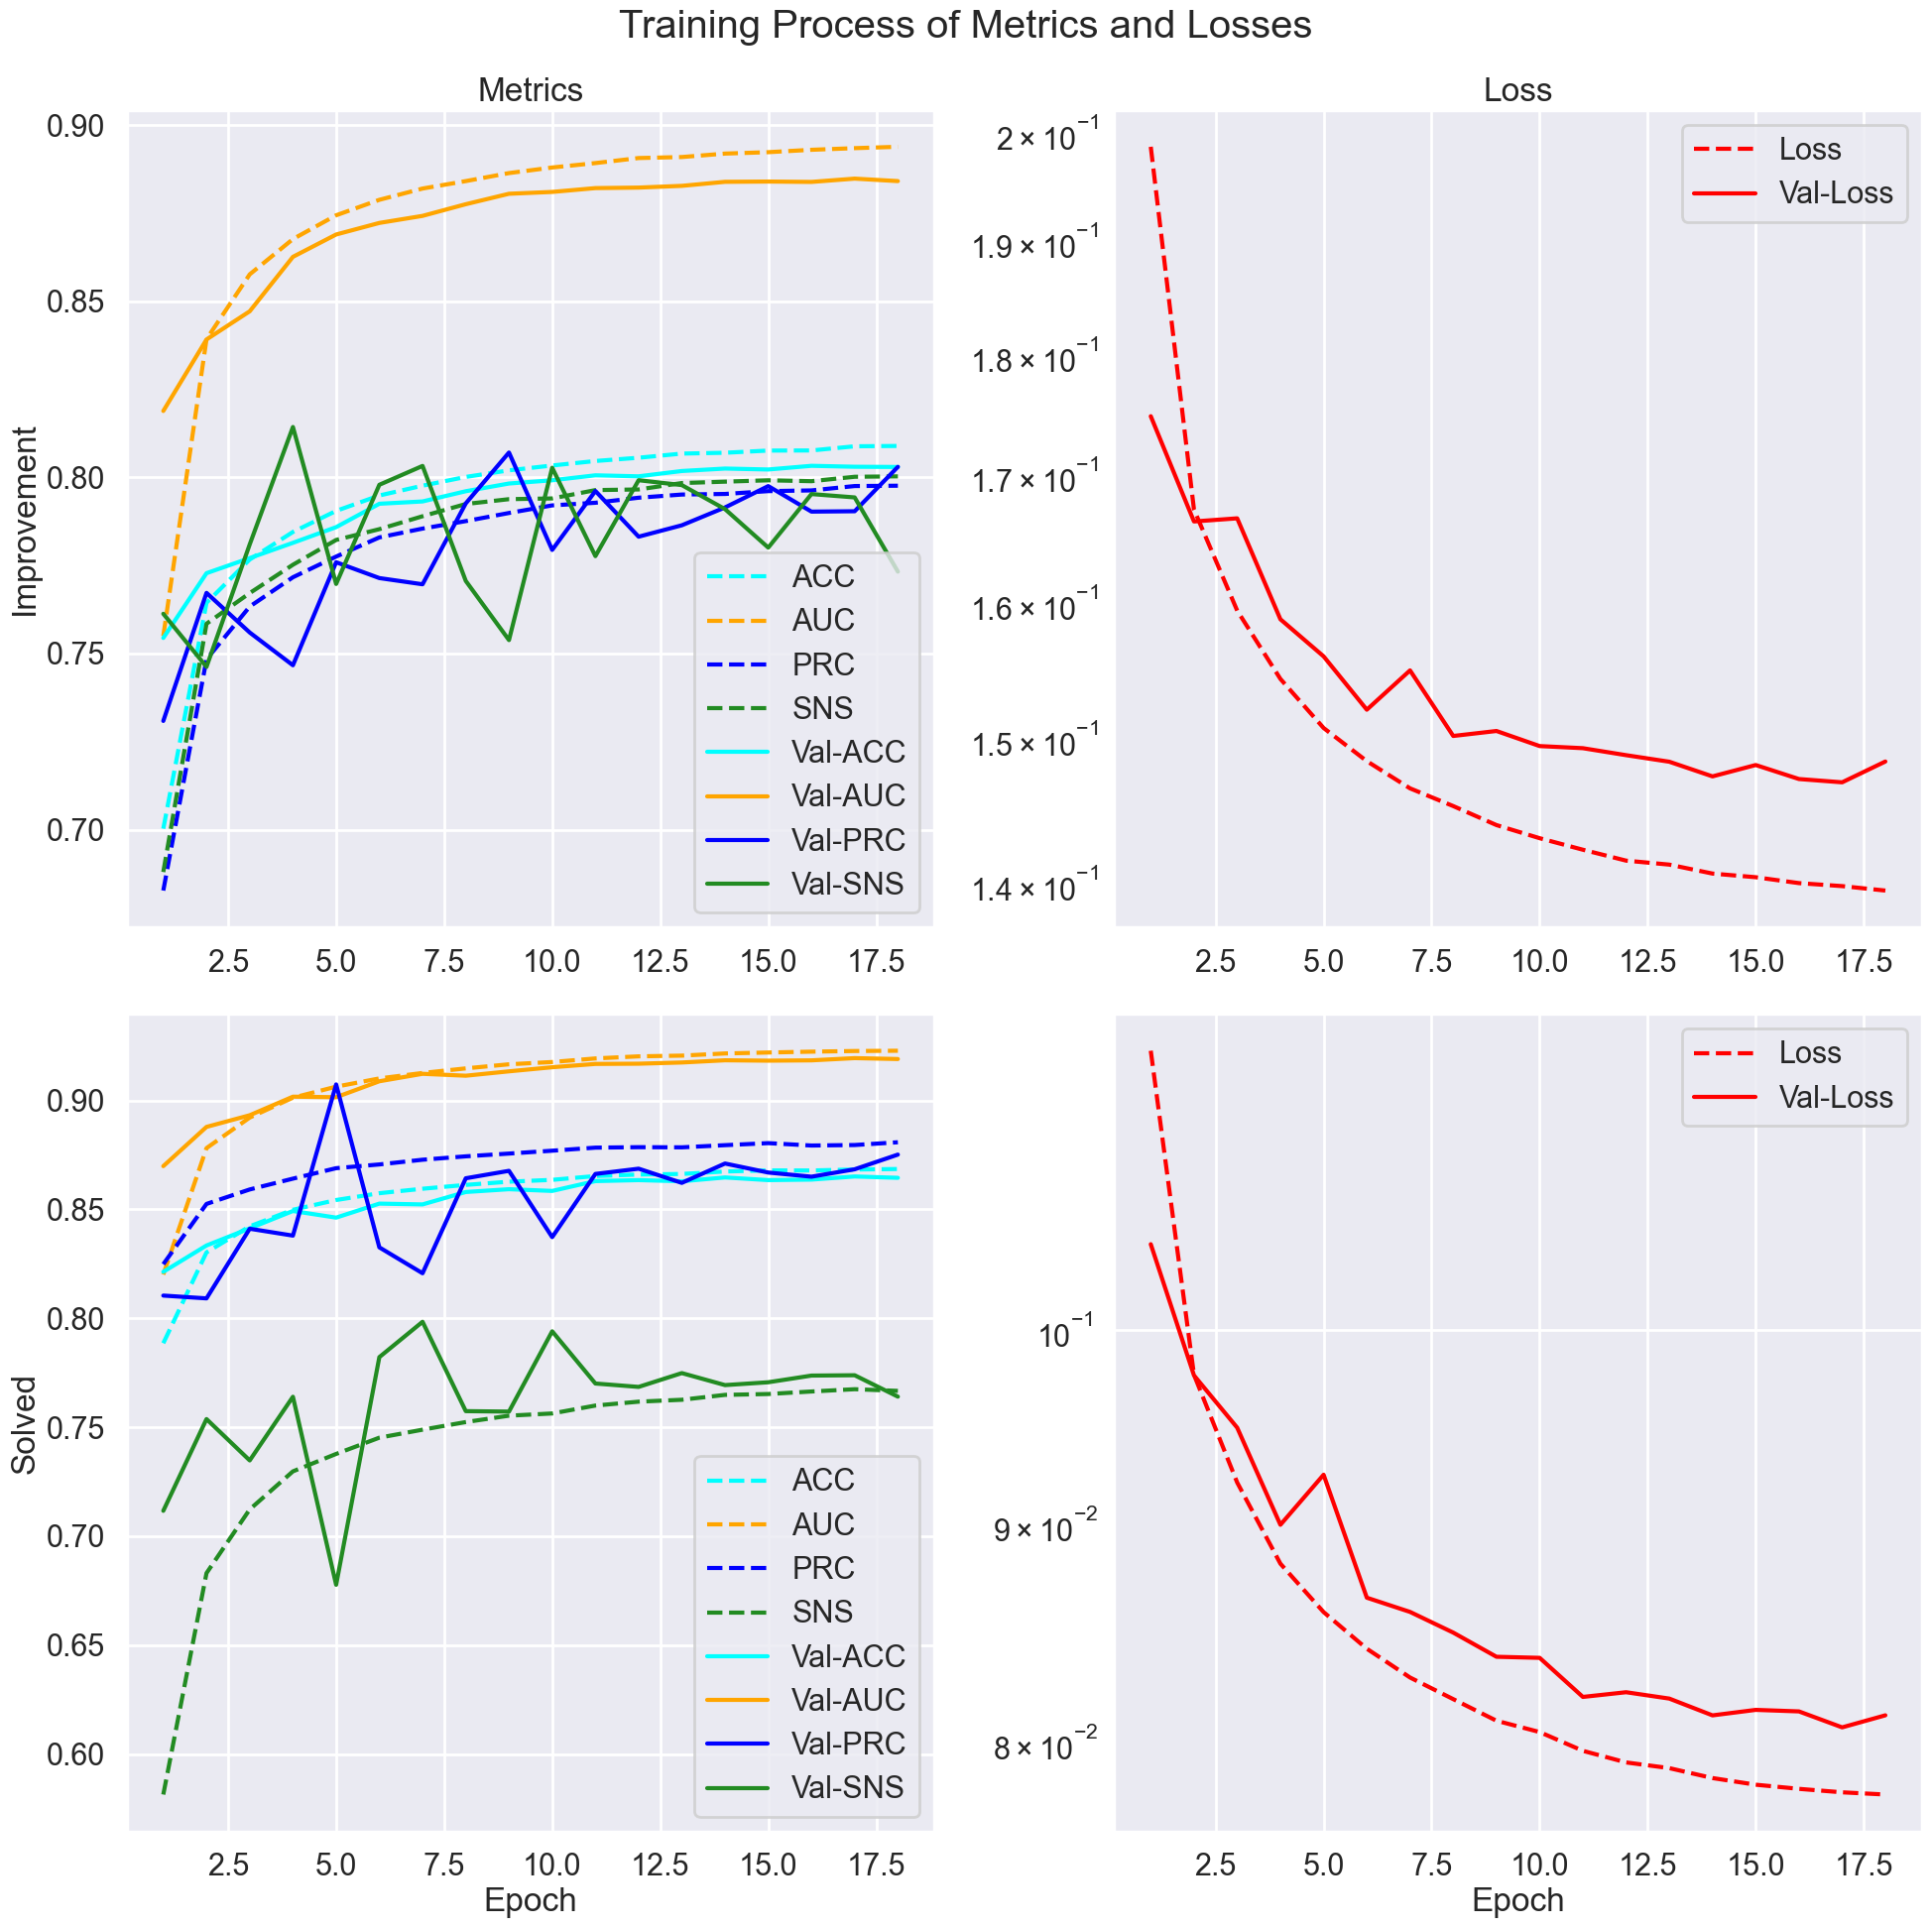

In [28]:
sns.set(context="poster")

clms = history.columns

fig, ax = plt.subplots(len(TARGET_LABELS), 2, figsize=(20, 10*len(TARGET_LABELS)))

colors = ["cyan", "orange", "blue", "forestgreen", "red", "purple"]

for i, target in enumerate(TARGET_LABELS):
    history.loc[(history.Target == target), (~clms.str.contains("Val-"))&(~clms.str.contains("Loss"))]\
        .plot(ax=ax[i, 0],ls = "--", color = colors, label = "Training")
    history.loc[(history.Target == target), (clms.str.contains("Val-"))&(~clms.str.contains("Loss"))]\
        .plot(ax=ax[i, 0], lw = 3, color = colors, label = "Validation")
    ax[i, 0].set(ylabel = target)

    # Plot the loss
    history.loc[(history.Target == target), (~clms.str.contains("Val-"))&(clms.str.contains("Loss"))]\
        .plot(ax=ax[i, 1], ls = "--", color = "red", label = "Training") 
    history.loc[(history.Target == target), (clms.str.contains("Val-"))&(clms.str.contains("Loss"))]\
        .plot(ax=ax[i, 1], lw = 3, color = "red", label = "Validation")
    ax[i, 1].set(yscale = "log")

ax[0, 0].set(
    title="Metrics",
    xlabel=""
)
ax[0, 1].set(
    title="Loss",
    xlabel=""
);


fig.suptitle("Training Process of Metrics and Losses")
fig.tight_layout()
plt.tight_layout()

for file_format in ["png", "jpg", "pdf", "svg"]:
    path = os.path.join(cwd, "plots", "2024-01-07-FinalModelTraining", f"LossByEpoch.{file_format}")
    plt.savefig(path)

sns.set(context="talk")

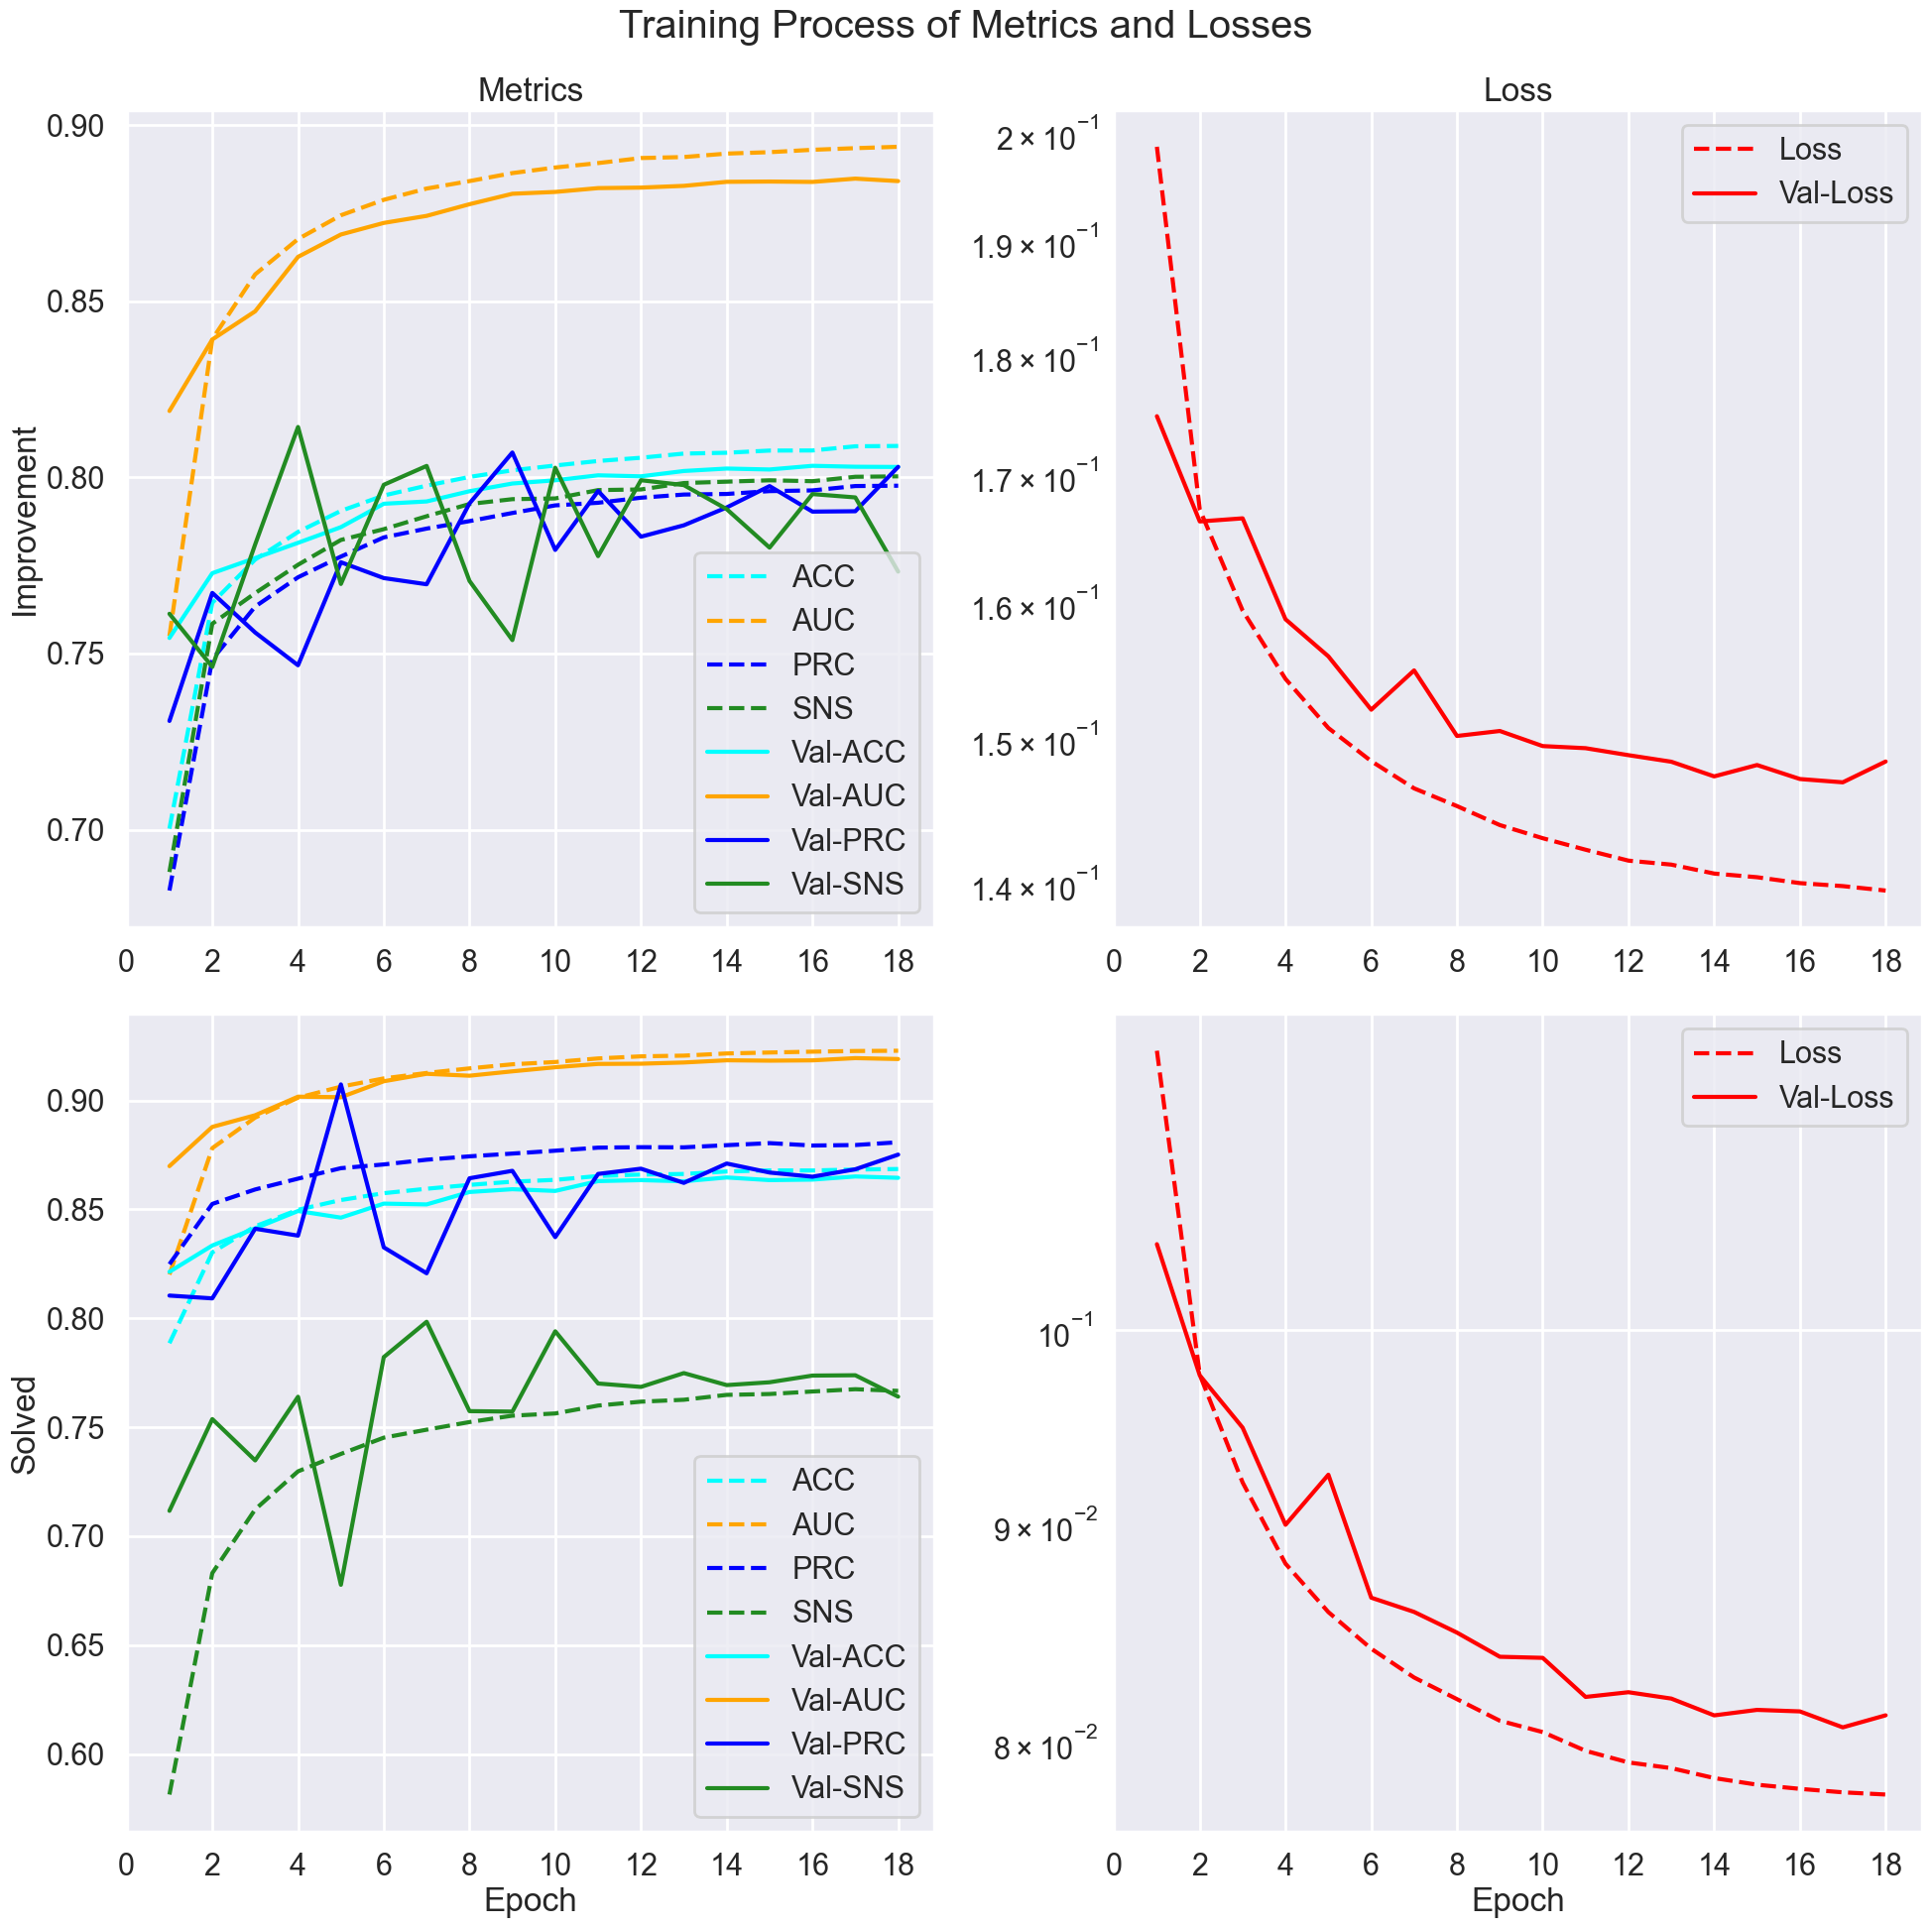

In [30]:
sns.set(context="poster")

clms = history.columns

fig, ax = plt.subplots(len(TARGET_LABELS), 2, figsize=(20, 10*len(TARGET_LABELS)))

colors = ["cyan", "orange", "blue", "forestgreen", "red", "purple"]

for i, target in enumerate(TARGET_LABELS):
    history.loc[(history.Target == target), (~clms.str.contains("Val-"))&(~clms.str.contains("Loss"))]\
        .plot(ax=ax[i, 0],ls = "--", color = colors, label = "Training")
    history.loc[(history.Target == target), (clms.str.contains("Val-"))&(~clms.str.contains("Loss"))]\
        .plot(ax=ax[i, 0], lw = 3, color = colors, label = "Validation")
    ax[i, 0].set(ylabel = target)

    # Plot the loss
    history.loc[(history.Target == target), (~clms.str.contains("Val-"))&(clms.str.contains("Loss"))]\
        .plot(ax=ax[i, 1], ls = "--", color = "red", label = "Training") 
    history.loc[(history.Target == target), (clms.str.contains("Val-"))&(clms.str.contains("Loss"))]\
        .plot(ax=ax[i, 1], lw = 3, color = "red", label = "Validation")
    ax[i, 1].set(yscale = "log")

ax[0, 0].set(
    title="Metrics",
    xlabel=""
)
ax[0, 1].set(
    title="Loss",
    xlabel=""
);


for i in [0, 1]:
    for j in [0, 1]:
        ax[i, j].set_xticks(range(0, 20, 2))

fig.suptitle("Training Process of Metrics and Losses")
fig.tight_layout()
plt.tight_layout()

for file_format in ["png", "jpg", "pdf", "svg"]:
    path = os.path.join(cwd, "plots", "2024-01-07-FinalModelTraining", f"LossByEpoch.{file_format}")
    plt.savefig(path)

sns.set(context="talk")

Tradeoff between Sensitivity and Precision can be seen very good here.
Most likely explanation:
- the bias of the final layer before the sigmoid has changed drastically.
- if the bias increases, predicted probabilities increase. This means more found solved cases and higher Sensitivity
- if the bias decreases, predicted probabilities decrease. This means less found solved cases, only the more certain cases. Higher Precision